In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!nvidia-smi

Wed Jun  4 08:52:42 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   54C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [5]:
import os
import cv2
import numpy as np
import string
import time
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

import tensorflow.keras.backend as K
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import (
    Dense, Reshape, BatchNormalization, Input,
    Conv2D, MaxPool2D, Lambda, Bidirectional, LSTM
)
from tensorflow.keras.models import Model
from tensorflow.keras.activations import relu, sigmoid, softmax
from tensorflow.keras.utils import to_categorical, Sequence
from tensorflow.keras.callbacks import ModelCheckpoint
from PIL import Image
from tqdm import tqdm
from collections import Counter


In [ ]:
tf.__version__

'2.18.0'

In [2]:
%cd /content/drive/MyDrive/

/content/drive/MyDrive


In [6]:
final_paths = []
final_texts = []

label_file = "DATASETPLATOCR/labels.txt"
image_folder = "DATASETPLATOCR/images"

with open(label_file, "r") as file:
    lines = file.readlines()

# Lewati baris-baris kosong atau angka indeks di awal
for line in lines:
    line = line.strip()
    if not line or line.isdigit():
        continue

    parts = line.split()
    if len(parts) >= 2:
        filename = parts[0]
        label = "".join(parts[1:])  # Gabungkan jika label mengandung spasi

        image_path = os.path.join(image_folder, filename)
        final_paths.append(image_path)
        final_texts.append(label)


In [7]:
final_paths[:10], final_texts[:10]

(['DATASETPLATOCR/images/B2823FW_plate.jpg',
  'DATASETPLATOCR/images/B2823FW_platee.jpg',
  'DATASETPLATOCR/images/AB15ML_plate.jpg',
  'DATASETPLATOCR/images/DD8080YU_plate.jpg',
  'DATASETPLATOCR/images/DD8080YU_platee.jpg',
  'DATASETPLATOCR/images/W1936RG_plate.jpg',
  'DATASETPLATOCR/images/B1947UOS_plate.jpg',
  'DATASETPLATOCR/images/1-E-3977-QM-09-19_jpg.rf.c52da3c5bc1b802f4f4f836ff49f7541_plate.jpg',
  'DATASETPLATOCR/images/1-E-3977-QM-09.jpg',
  'DATASETPLATOCR/images/101-E-4604-PS-09-17_jpg.rf.2f4c97dee87f9e84df1a8420a06e37ce_plate.jpg'],
 ['B2823FW',
  'B2823FW',
  'AB15ML',
  'DD8080YU',
  'DD8080YU',
  'W1936RG',
  'B1947UOS',
  'E3977QM',
  'E3977QM',
  'E4604PS'])

In [8]:
### get vocab from dataset
vocab = set("".join(map(str, final_texts)))
print(sorted(vocab))

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


In [9]:
from collections import Counter
Counter("".join(map(str, final_texts)))

Counter({'B': 779,
         '2': 857,
         '8': 587,
         '3': 787,
         'F': 251,
         'W': 96,
         'A': 760,
         '1': 1124,
         '5': 677,
         'M': 156,
         'L': 116,
         'D': 414,
         '0': 456,
         'Y': 104,
         'U': 137,
         '9': 652,
         '6': 676,
         'R': 208,
         'G': 254,
         '4': 729,
         '7': 603,
         'O': 124,
         'S': 211,
         'E': 639,
         'Q': 185,
         'P': 222,
         'Z': 96,
         'T': 214,
         'V': 80,
         'C': 129,
         'K': 279,
         'N': 139,
         'I': 101,
         'X': 53,
         'H': 188,
         'J': 72})

In [10]:
char_list = sorted(vocab)
print(f"Vocabulary: {char_list}")
print(f"Vocabulary size: {len(char_list)}")

def encode_to_labels(txt):
    """Encode text to label indices"""
    dig_lst = []
    for char in txt:
        try:
            dig_lst.append(char_list.index(char))
        except ValueError:
            print(f"Character '{char}' not in vocabulary")
    return dig_lst

Vocabulary: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
Vocabulary size: 36


In [11]:
# Split data
train_final_paths = final_paths[ : int(len(final_paths) * 0.90)]
train_final_texts = final_texts[ : int(len(final_texts) * 0.90)]

val_final_paths = final_paths[int(len(final_paths) * 0.90) : ]
val_final_texts = final_texts[int(len(final_texts) * 0.90) : ]
print(f"Training samples: {len(train_final_paths)}")
print(f"Validation samples: {len(val_final_paths)}")

max_label_len = max([len(str(text)) for text in final_texts])
print(f"Maximum label length: {max_label_len}")

Training samples: 1660
Validation samples: 185
Maximum label length: 10


In [12]:
class OCR_Generator(Sequence):
    def __init__(self, image_filenames, labels, batch_size, char_list, max_label_len):
        self.image_filenames = image_filenames
        self.labels = labels
        self.batch_size = batch_size
        self.char_list = char_list
        self.max_label_len = max_label_len
        super().__init__()  # Fix for the warning

    def __len__(self):
        return int(np.ceil(len(self.image_filenames) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_paths = self.image_filenames[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_texts = self.labels[idx * self.batch_size:(idx + 1) * self.batch_size]

        images = []
        training_txt = []
        train_label_length = []
        train_input_length = []

        for im_path, text in zip(batch_paths, batch_texts):
            try:
                text = str(text).strip()
                img = cv2.imread(im_path, cv2.IMREAD_GRAYSCALE)

                if img is None:
                    print(f"Could not load image: {im_path}")
                    continue

                h, w = img.shape

                # Pad height to 32 if needed
                if h < 32:
                    add_zeros = np.ones((32-h, w)) * 255
                    img = np.concatenate((img, add_zeros))
                    h = 32

                # Pad width to 128 if needed
                if w < 128:
                    add_zeros = np.ones((h, 128-w)) * 255
                    img = np.concatenate((img, add_zeros), axis=1)
                    w = 128

                # Resize if larger than target size
                if w > 128 or h > 32:
                    img = cv2.resize(img, (128, 32))

                # Add channel dimension and normalize
                img = np.expand_dims(img, axis=2)
                img = img / 255.0

                images.append(img)
                training_txt.append(encode_to_labels(text))
                train_label_length.append(len(text))
                # Input length calculation based on CNN feature map width
                train_input_length.append(31)  # After CNN layers: 128 -> 64 -> 32 -> 31

            except Exception as e:
                print(f"Error processing image {im_path}: {e}")
                continue

        # Ensure we have data
        if not images:
            # Return empty batch with proper shapes
            return {
                'input_1': np.zeros((1, 32, 128, 1)),
                'the_labels': np.zeros((1, self.max_label_len)),
                'input_length': np.ones((1, 1)) * 31,
                'label_length': np.ones((1, 1))
            }, np.zeros((1,))

        # Pad sequences
        padded_labels = pad_sequences(training_txt, maxlen=self.max_label_len,
                                    padding='post', value=len(self.char_list))

        return {
            'input_1': np.array(images),
            'the_labels': np.array(padded_labels),
            'input_length': np.array(train_input_length).reshape(-1, 1),
            'label_length': np.array(train_label_length).reshape(-1, 1)
        }, np.zeros(len(images))


In [13]:
# Build the model
def build_model(char_list, max_label_len):
    # Input layer
    inputs = Input(shape=(32, 128, 1), name='input_1')

    # CNN layers
    conv_1 = Conv2D(16, (3,3), activation='relu', padding='same')(inputs)
    pool_1 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_1)

    conv_2 = Conv2D(32, (3,3), activation='relu', padding='same')(pool_1)
    pool_2 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_2)

    conv_3 = Conv2D(64, (3,3), activation='relu', padding='same')(pool_2)
    conv_4 = Conv2D(64, (3,3), activation='relu', padding='same')(conv_3)
    pool_4 = MaxPool2D(pool_size=(2, 1))(conv_4)

    conv_5 = Conv2D(64, (3,3), activation='relu', padding='same')(pool_4)
    batch_norm_5 = BatchNormalization()(conv_5)

    conv_6 = Conv2D(64, (3,3), activation='relu', padding='same')(batch_norm_5)
    batch_norm_6 = BatchNormalization()(conv_6)
    pool_6 = MaxPool2D(pool_size=(2, 1))(batch_norm_6)

    conv_7 = Conv2D(64, (2,2), activation='relu')(pool_6)

    # Squeeze and RNN layers
    squeezed = Lambda(lambda x: K.squeeze(x, axis=1))(conv_7)
    blstm_1 = Bidirectional(LSTM(128, return_sequences=True))(squeezed)
    blstm_2 = Bidirectional(LSTM(128, return_sequences=True))(blstm_1)

    outputs = Dense(len(char_list) + 1, activation='softmax')(blstm_2)

    # Model for prediction
    act_model = Model(inputs, outputs)

    # Model for training with CTC loss
    labels = Input(name='the_labels', shape=[max_label_len], dtype='float32')
    input_length = Input(name='input_length', shape=[1], dtype='int64')
    label_length = Input(name='label_length', shape=[1], dtype='int64')

    def ctc_lambda_func(args):
        y_pred, labels, input_length, label_length = args
        return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

    loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')(
        [outputs, labels, input_length, label_length])
    # Training model
    model = Model(inputs=[inputs, labels, input_length, label_length], outputs=loss_out)

    return model, act_model

# Create model
model, act_model = build_model(char_list, max_label_len)

# Compile model
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer='adam')

print("Model summary:")
act_model.summary()

Model summary:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_1 (InputLayer)            │ (None, 32, 128, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 128, 16)    │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 64, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 32, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 32, 64)      │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 32, 64)      │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 32, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 4, 32, 64)      │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 4, 32, 64)      │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 4, 32, 64)      │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 4, 32, 64)      │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 2, 32, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 1, 31, 64)      │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 31, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 31, 256)        │       197,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 31, 256)        │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 31, 37)         │         9,509 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 752,421 (2.87 MB)

 Trainable params: 752,165 (2.87 MB)

 Non-trainable params: 256 (1.00 KB)

In [14]:
train_final_paths[:1], train_final_texts[:1]

(['DATASETPLATOCR/images/B2823FW_plate.jpg'], ['B2823FW'])

In [15]:
# Create generators
batch_size = 16  # Reduced batch size to avoid memory issues
train_generator = OCR_Generator(train_final_paths, train_final_texts, batch_size, char_list, max_label_len)
val_generator = OCR_Generator(val_final_paths, val_final_texts, batch_size, char_list, max_label_len)


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Callbacks
file_path = "OCR_CRNN.keras"

checkpoint = ModelCheckpoint(
    filepath=file_path,
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min'
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,             # Jumlah epoch tanpa perbaikan sebelum dihentikan
    restore_best_weights=True,  # Kembalikan bobot terbaik
    verbose=1
)

# Train the model
epochs = 50
print(f"Starting training for {epochs} epochs...")

try:
    history = model.fit(
        train_generator,
        epochs=epochs,
        validation_data=val_generator,
        verbose=1,
        callbacks=[checkpoint, early_stop]
    )
    print("Training completed successfully!")

except Exception as e:
    print(f"Training error: {e}")


Starting training for 50 epochs...
Epoch 1/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - loss: 29.2212
Epoch 1: val_loss improved from inf to 24.05828, saving model to OCR_CRNN.keras


/usr/local/lib/python3.11/dist-packages/keras/src/saving/serialization_lib.py:390: UserWarning: The object being serialized includes a `lambda`. This is unsafe. In order to reload the object, you will have to pass `safe_mode=False` to the loading function. Please avoid using `lambda` in the future, and use named Python functions instead. This is the `lambda` being serialized: model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer='adam')

  return {key: serialize_keras_object(value) for key, value in obj.items()}


104/104 ━━━━━━━━━━━━━━━━━━━━ 833s 8s/step - loss: 29.1780 - val_loss: 24.0583
Epoch 2/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step - loss: 21.3485
Epoch 2: val_loss improved from 24.05828 to 23.06221, saving model to OCR_CRNN.keras
104/104 ━━━━━━━━━━━━━━━━━━━━ 34s 325ms/step - loss: 21.3471 - val_loss: 23.0622
Epoch 3/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step - loss: 20.3638
Epoch 3: val_loss improved from 23.06221 to 20.85028, saving model to OCR_CRNN.keras
104/104 ━━━━━━━━━━━━━━━━━━━━ 34s 330ms/step - loss: 20.3640 - val_loss: 20.8503
Epoch 4/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - loss: 20.1711
Epoch 4: val_loss did not improve from 20.85028
104/104 ━━━━━━━━━━━━━━━━━━━━ 32s 310ms/step - loss: 20.1701 - val_loss: 20.8625
Epoch 5/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step - loss: 19.6364
Epoch 5: val_loss did not improve from 20.85028
104/104 ━━━━━━━━━━━━━━━━━━━━ 34s 331ms/step - loss: 19.6367 - val_loss: 22.7183
Epoch 6/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - 

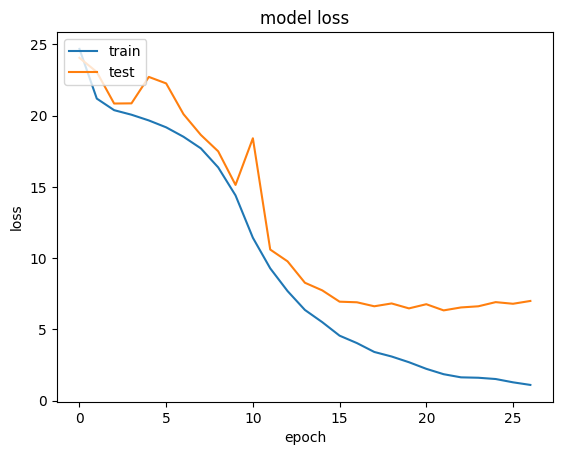

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [16]:
act_model.load_weights("/content/drive/MyDrive/OCR_CRNN.keras")

In [19]:

from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow.keras.backend as K
import numpy as np
import editdistance
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm # Import tqdm for the progress bar

# Redefine file_path to ensure it's available
file_path = "/content/drive/MyDrive/OCR_CRNN.keras" # Make sure this path matches the save path

# Function to decode output of the model
def decode_batch_predictions(pred, char_list):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you might want to use beam search
    results = K.ctc_decode(pred, input_length=input_len, greedy=True)[0][0]
    output_text = []
    for res in results.numpy():
        # Ensure predicted character index is within the bounds of char_list
        out = ''.join([char_list[int(char)] for char in res if int(char) != -1 and int(char) < len(char_list)])
        output_text.append(out)
    return output_text

# Load the best model saved by the checkpoint
try:
    # When loading a model saved with ModelCheckpoint using .keras format,
    # you generally load the entire model, which includes the architecture.
    # However, if you saved *only* weights, you need to rebuild the model
    # architecture first and then load the weights.
    # Based on the file_path "OCR_CRNN.keras", it's likely you saved the whole model.
    loaded_model = load_model(file_path, compile=False) # Load the entire model
    print(f"Successfully loaded model from {file_path}")

except Exception as e:
    print(f"Error loading the model directly from {file_path}: {e}")
    print("Attempting to load weights onto the pre-defined 'act_model'...")
    # If loading the whole model fails, try loading weights onto the act_model
    # This requires that `act_model` was created in a previous cell and is available
    try:
        if 'act_model' in globals():
            act_model.load_weights(file_path)
            loaded_model = act_model # Use the model defined in the notebook with loaded weights
            print(f"Successfully loaded weights onto 'act_model' from {file_path}")
        else:
             print("'act_model' is not defined. Cannot load weights.")
             loaded_model = None
    except Exception as e2:
        print(f"Error loading weights onto 'act_model': {e2}")
        loaded_model = None


if loaded_model:
    print("Model is ready for evaluation.")

    # Evaluate on validation data
    print("Evaluating on validation data...")

    predictions = []
    actual_labels = []

    # Use the validation generator to get batches
    # We need to iterate through the generator to get images and true labels
    # Use tqdm to show progress
    for i in tqdm(range(len(val_generator))):
        # Corrected unpacking: The generator returns a tuple (inputs_dict, dummy_targets)
        batch_data, _ = val_generator[i] # Get a batch from the generator, ignore dummy targets
        batch_images = batch_data['input_1']
        batch_true_labels_encoded = batch_data['the_labels']
        batch_label_lengths = batch_data['label_length']

        # Predict raw output from the model
        # Ensure the input to predict is of the correct shape and type
        batch_preds = loaded_model.predict(batch_images)

        # Decode predictions
        decoded_preds = decode_batch_predictions(batch_preds, char_list)
        predictions.extend(decoded_preds)

        # Decode true labels from encoded format
        batch_actual_labels = []
        for encoded_labels, length in zip(batch_true_labels_encoded, batch_label_lengths):
             # Decode only the actual label part, excluding padding
            # Ensure decoded character index is within the bounds of char_list
            actual_label_decoded = ''.join([char_list[int(char)] for char in encoded_labels[:int(length)] if int(char) != -1 and int(char) < len(char_list)])
            batch_actual_labels.append(actual_label_decoded)

        actual_labels.extend(batch_actual_labels)

    # Calculate Accuracy
    correct_predictions = sum([1 for pred, actual in zip(predictions, actual_labels) if pred == actual])
    accuracy = correct_predictions / len(actual_labels) if len(actual_labels) > 0 else 0

    print(f"\nAccuracy: {accuracy:.4f}")

    # Calculate Levenshtein Distance (Edit Distance)
    # Use max(1, ...) in case of empty ground truth labels to avoid division by zero
    edit_distances = [editdistance.eval(pred, actual) for pred, actual in zip(predictions, actual_labels)]
    mean_edit_distance = np.mean(edit_distances) if len(edit_distances) > 0 else 0

    print(f"Mean Edit Distance: {mean_edit_distance:.4f}")

    # Character Error Rate (CER) - Average edit distance normalized by the length of the ground truth text
    cer_scores = [editdistance.eval(pred, actual) / max(1, len(actual)) for pred, actual in zip(predictions, actual_labels)]
    mean_cer = np.mean(cer_scores) if len(cer_scores) > 0 else 0

    print(f"Mean Character Error Rate (CER): {mean_cer:.4f}")

    # Word Error Rate (WER) - Treat each character sequence between spaces as a "word".
    # This is less standard for character-level OCR but can give insight into full word errors.
    # For this dataset (license plates), words are less relevant. CER is usually more appropriate.
    # We'll skip a formal WER calculation here as the dataset doesn't have standard words.

    # Precision and Recall (Character level)
    # This is complex for sequences. A simple approach is to consider characters as positives/negatives.
    # However, the position matters. A common way is to use character n-grams or treat it as
    # a sequence comparison problem (like edit distance).
    # A true Precision/Recall calculation per class (character) would require a more detailed
    # alignment or treating every character prediction as a separate instance, which is
    # not standard for end-to-end OCR.

    # For simplicity and relevance to OCR, Accuracy, CER, and potentially Word Accuracy
    # (exact match of the whole predicted string to the ground truth) are more common metrics.

    # Example: Word Accuracy (Same as the 'Accuracy' calculated above for this case)
    word_accuracy = accuracy
    print(f"Word Accuracy (Exact Match): {word_accuracy:.4f}")

    # Display some example predictions vs actuals
    print("\nExamples:")
    for i in range(min(10, len(predictions))):
        print(f"Actual: {actual_labels[i]}, Predicted: {predictions[i]}")

else:
    print("Model could not be loaded. Evaluation skipped.")

Error loading the model directly from /content/drive/MyDrive/OCR_CRNN.keras: The `{arg_name}` of this `Lambda` layer is a Python lambda. Deserializing it is unsafe. If you trust the source of the config artifact, you can override this error by passing `safe_mode=False` to `from_config()`, or calling `keras.config.enable_unsafe_deserialization().
Attempting to load weights onto the pre-defined 'act_model'...
Successfully loaded weights onto 'act_model' from /content/drive/MyDrive/OCR_CRNN.keras
Model is ready for evaluation.
Evaluating on validation data...


  0%|          | 0/12 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


<ipython-input-19-c293da0f66f5>:87: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  actual_label_decoded = ''.join([char_list[int(char)] for char in encoded_labels[:int(length)] if int(char) != -1 and int(char) < len(char_list)])
  8%|▊         | 1/12 [00:02<00:26,  2.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


 17%|█▋        | 2/12 [00:18<01:45, 10.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 25%|██▌       | 3/12 [00:29<01:34, 10.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 33%|███▎      | 4/12 [00:39<01:24, 10.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 42%|████▏     | 5/12 [00:51<01:16, 10.91s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


 50%|█████     | 6/12 [01:00<01:02, 10.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 58%|█████▊    | 7/12 [01:14<00:58, 11.66s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


 67%|██████▋   | 8/12 [01:25<00:45, 11.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


 75%|███████▌  | 9/12 [01:34<00:32, 10.69s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


 83%|████████▎ | 10/12 [01:44<00:20, 10.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


 92%|█████████▏| 11/12 [01:55<00:10, 10.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 767ms/step


100%|██████████| 12/12 [02:03<00:00, 10.26s/it]


Accuracy: 0.5081
Mean Edit Distance: 1.4054
Mean Character Error Rate (CER): 0.1990
Word Accuracy (Exact Match): 0.5081

Examples:
Actual: B3326UB, Predicted: B3326UB
Actual: B3559SU, Predicted: B3559SU
Actual: B3600LO, Predicted: B3600LO
Actual: B3675BN, Predicted: B3675BW
Actual: B4272BM, Predicted: B4272BM
Actual: B5571SA, Predicted: B5571SA
Actual: BA5751Y, Predicted: BA5751Y
Actual: BA5752Y, Predicted: BA5752Y
Actual: BA5756Y, Predicted: BA5756Y
Actual: BA5757Y, Predicted: BA5757Y


In [ ]:
from keras import config
config.enable_unsafe_deserialization()


In [ ]:
def predict_output(img):
    # predict outputs on validation images
    prediction = act_model.predict(np.array([img]))
    ## shape (batch_size, num_timesteps, vocab_size)

    # use CTC decoder
    out = K.get_value(K.ctc_decode(prediction,
                                   input_length=np.ones(prediction.shape[0]) * prediction.shape[1],
                                   greedy=True)[0][0])

    ## get the final text
    for x in out:

        print("predicted text = ", end = '')

        for p in x:

            if int(p) != -1:
                print(char_list[int(p)], end = '')

        print('\n')

In [ ]:

def pre_process_image(path):

    img = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2GRAY)
    ### actually returns h, w
    h, w = img.shape

    ### if height less than 32
    if h < 32:
        add_zeros = np.ones((32-h, w)) * 255
        img = np.concatenate((img, add_zeros))
        h = 32

    ## if width less than 128
    if w < 128:
        add_zeros = np.ones((h, 128-w)) * 255
        img = np.concatenate((img, add_zeros), axis=1)
        w = 128

    ### if width is greater than 128 or height greater than 32
    if w > 128 or h > 32:
        img = cv2.resize(img, (128, 32))


    img = np.expand_dims(img , axis = 2)

    # Normalize each image
    img = img / 255.

    return img

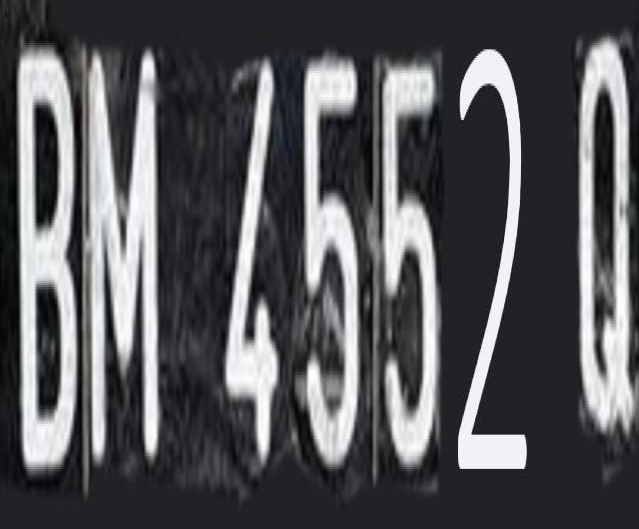



1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 751ms/step
predicted text = BM45552Q





1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
predicted text = E19FS



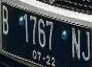



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
predicted text = B167B



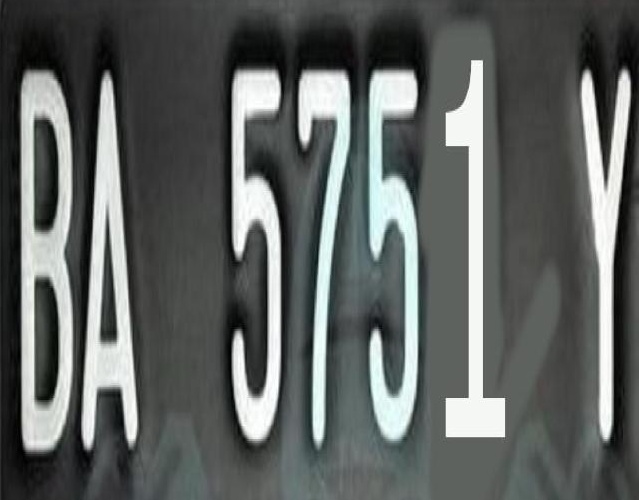



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
predicted text = BA5751Y



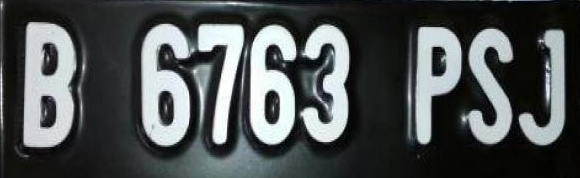



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
predicted text = B6763PSA



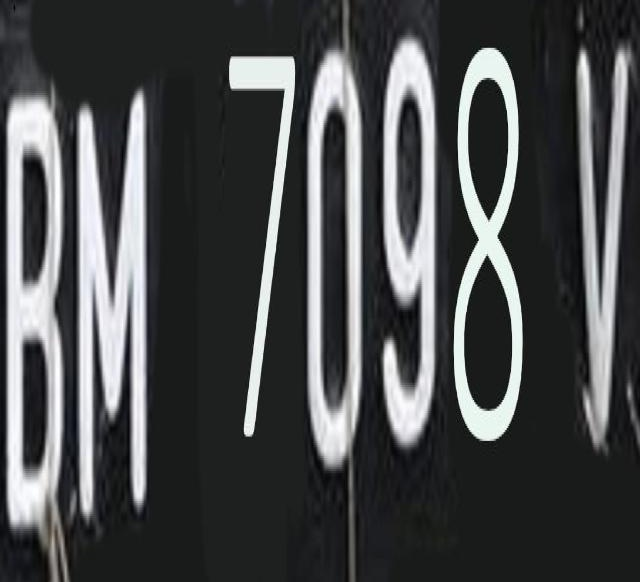



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
predicted text = BM7098V



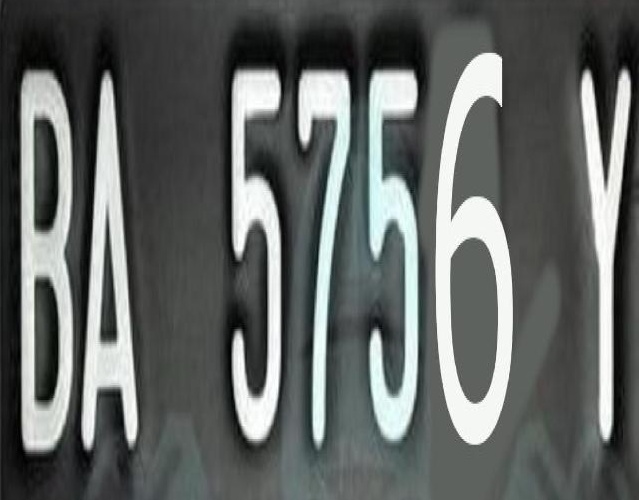



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
predicted text = BA5756Y



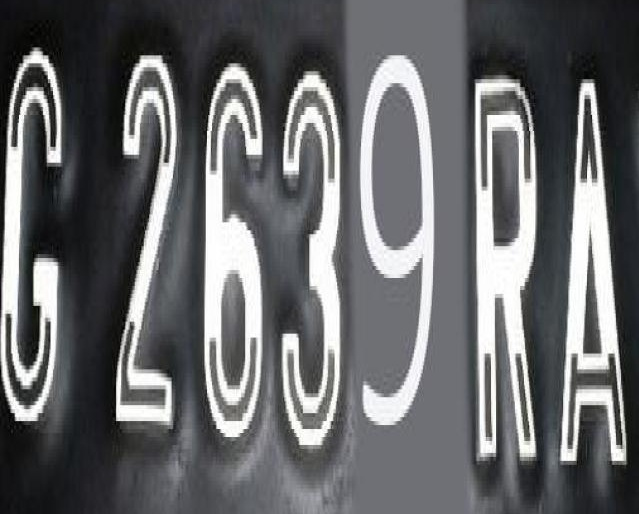



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
predicted text = G2639RA



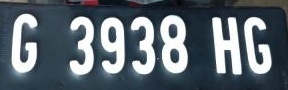



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
predicted text = G3938HG



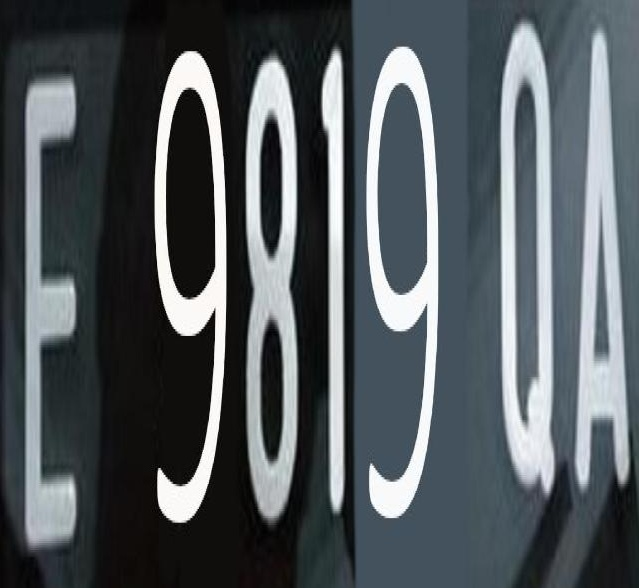



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
predicted text = E9819QA



In [ ]:
from IPython.display import display
from random import randrange

for i in range(10):
    index = randrange(len(val_final_paths))
    im = Image.open(val_final_paths[index])
    display(im)

    print("\n")

    test_img = pre_process_image(val_final_paths[index])
    predict_output(test_img)


Loaded model weights from: /content/drive/MyDrive/OCR_CRNN.keras


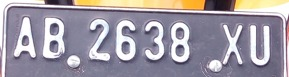

Processing image: /content/drive/MyDrive/crop.jpg
Preprocessed image shape: (32, 128, 1)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predicted text: 'AB2638D'


In [ ]:
import os
import cv2
import numpy as np
import string
import time
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

import tensorflow.keras.backend as K
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import (
    Dense, Reshape, BatchNormalization, Input,
    Conv2D, MaxPool2D, Lambda, Bidirectional, LSTM
)
from tensorflow.keras.models import Model
from tensorflow.keras.activations import relu, sigmoid, softmax
from tensorflow.keras.utils import to_categorical, Sequence
from tensorflow.keras.callbacks import ModelCheckpoint

# Fix for TensorFlow 2.x compatibility
try:
    from tensorflow.python.keras.backend import get_value
    from tensorflow.python.keras.backend import ctc_decode
except ImportError:
    from tensorflow.keras.backend import get_value
    from tensorflow.keras.backend import ctc_decode
from PIL import Image
from tqdm import tqdm
from collections import Counter
from IPython.display import display

# Define vocabulary
char_list = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
max_label_len = 10  # Adjust based on your dataset

# Build the model
def build_model(char_list, max_label_len):
    # Input layer
    inputs = Input(shape=(32, 128, 1), name='input_1')

    # CNN layers
    conv_1 = Conv2D(16, (3,3), activation='relu', padding='same')(inputs)
    pool_1 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_1)

    conv_2 = Conv2D(32, (3,3), activation='relu', padding='same')(pool_1)
    pool_2 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_2)

    conv_3 = Conv2D(64, (3,3), activation='relu', padding='same')(pool_2)
    conv_4 = Conv2D(64, (3,3), activation='relu', padding='same')(conv_3)
    pool_4 = MaxPool2D(pool_size=(2, 1))(conv_4)

    conv_5 = Conv2D(64, (3,3), activation='relu', padding='same')(pool_4)
    batch_norm_5 = BatchNormalization()(conv_5)

    conv_6 = Conv2D(64, (3,3), activation='relu', padding='same')(batch_norm_5)
    batch_norm_6 = BatchNormalization()(conv_6)
    pool_6 = MaxPool2D(pool_size=(2, 1))(batch_norm_6)

    conv_7 = Conv2D(64, (2,2), activation='relu')(pool_6)

    # Squeeze and RNN layers
    squeezed = Lambda(lambda x: K.squeeze(x, axis=1))(conv_7)
    blstm_1 = Bidirectional(LSTM(128, return_sequences=True))(squeezed)
    blstm_2 = Bidirectional(LSTM(128, return_sequences=True))(blstm_1)

    outputs = Dense(len(char_list) + 1, activation='softmax')(blstm_2)

    # Model for prediction
    act_model = Model(inputs, outputs)

    # Model for training with CTC loss
    labels = Input(name='the_labels', shape=[max_label_len], dtype='float32')
    input_length = Input(name='input_length', shape=[1], dtype='int64')
    label_length = Input(name='label_length', shape=[1], dtype='int64')

    def ctc_lambda_func(args):
        y_pred, labels, input_length, label_length = args
        # Fix for different TensorFlow versions
        try:
            return K.ctc_batch_cost(labels, y_pred, input_length, label_length)
        except:
            # Alternative for newer TF versions
            return tf.nn.ctc_loss(
                labels=tf.cast(labels, tf.int32),
                logits=y_pred,
                logit_length=tf.cast(tf.squeeze(input_length), tf.int32),
                label_length=tf.cast(tf.squeeze(label_length), tf.int32),
                blank_index=-1
            )

    loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')(
        [outputs, labels, input_length, label_length])
    # Training model
    model = Model(inputs=[inputs, labels, input_length, label_length], outputs=loss_out)

    return model, act_model

def predict_output(img, act_model, char_list):
    """Predict text from preprocessed image"""
    try:
        # predict outputs on validation images
        prediction = act_model.predict(np.array([img]))
        ## shape (batch_size, num_timesteps, vocab_size)

        # use CTC decoder - Fixed for TensorFlow 2.x compatibility
        input_len = np.ones(prediction.shape[0]) * prediction.shape[1]

        # Try different approaches for CTC decode based on TF version
        try:
            # Method 1: Direct K.ctc_decode
            decoded = K.ctc_decode(prediction, input_length=input_len, greedy=True)
            out = K.get_value(decoded[0][0])
        except Exception as e1:
            try:
                # Method 2: Using tf.nn.ctc_greedy_decoder
                decoded = tf.nn.ctc_greedy_decoder(
                    tf.transpose(prediction, [1, 0, 2]),
                    sequence_length=input_len.astype(np.int32)
                )
                out = decoded[0][0].numpy()
            except Exception as e2:
                # Method 3: Manual decode
                print(f"CTC decode error: {e1}, {e2}")
                out = np.argmax(prediction, axis=2)

        ## get the final text
        predicted_text = ""
        if len(out.shape) > 1:
            for x in out:
                for p in x:
                    if int(p) != -1 and int(p) < len(char_list):
                        predicted_text += char_list[int(p)]
        else:
            for p in out:
                if int(p) != -1 and int(p) < len(char_list):
                    predicted_text += char_list[int(p)]

        return predicted_text

    except Exception as e:
        print(f"Error in prediction: {e}")
        return ""

def pre_process_image(path):
    """Preprocess image for OCR model"""
    img = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2GRAY)

    ### actually returns h, w
    h, w = img.shape

    ### if height less than 32
    if h < 32:
        add_zeros = np.ones((32-h, w)) * 255
        img = np.concatenate((img, add_zeros))
        h = 32

    ## if width less than 128
    if w < 128:
        add_zeros = np.ones((h, 128-w)) * 255
        img = np.concatenate((img, add_zeros), axis=1)
        w = 128

    ### if width is greater than 128 or height greater than 32
    if w > 128 or h > 32:
        img = cv2.resize(img, (128, 32))

    img = np.expand_dims(img, axis=2)

    # Normalize each image
    img = img / 255.

    return img

def predict_single_image(image_path, model_weights_path=None):
    """Process and predict text from a single image"""
    try:
        # Build model
        model, act_model = build_model(char_list, max_label_len)

        # Load weights if provided
        if model_weights_path and os.path.exists(model_weights_path):
            model.load_weights(model_weights_path)
            print(f"Loaded model weights from: {model_weights_path}")
        else:
            print("Warning: No model weights loaded. Model needs to be trained first.")

        # Display original image
        im = Image.open(image_path)
        display(im)
        print(f"Processing image: {image_path}")

        # Preprocess image
        test_img = pre_process_image(image_path)
        print(f"Preprocessed image shape: {test_img.shape}")

        # Predict text
        predicted_text = predict_output(test_img, act_model, char_list)

        print(f"Predicted text: '{predicted_text}'")
        return predicted_text

    except Exception as e:
        print(f"Error processing image: {e}")
        return None

# Usage examples:

# Method 1: If you have trained model weights
predicted_text = predict_single_image("/content/drive/MyDrive/crop.jpg", "/content/drive/MyDrive/OCR_CRNN.keras")

